# **Data Preparation**

I have used pre-trained FastText Wikipedia embeddings for English and Hindi (300-dimensional vectors) to avoid training from scratch​. The vocabulary in each language is truncated to the top 100,000 most frequent words for efficiency, as suggested in the assignment

In [ ]:
!wget -q -O cc.en.300.vec.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!wget -q -O cc.hi.300.vec.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
!gunzip cc.en.300.vec.gz
!gunzip cc.hi.300.vec.gz


In [ ]:
import numpy as np

def load_embeddings(file_path, top_n=100000):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        header = f.readline()
        for i, line in enumerate(f):
            if i >= top_n: break
            parts = line.rstrip().split(' ')
            if len(parts) < 2:
                continue
            word = parts[0]
            vec = np.array(parts[1:], dtype=float)
            embeddings[word] = vec
    return embeddings

# Loading top 100k English and Hindi embeddings
eng_embeddings = load_embeddings("cc.en.300.vec", top_n=100000)
hi_embeddings  = load_embeddings("cc.hi.300.vec", top_n=100000)
print(f"Loaded {len(eng_embeddings)} English and {len(hi_embeddings)} Hindi word vectors.")


Loaded 100000 English and 100000 Hindi word vectors.


In [ ]:
def normalize_embeddings(embed_dict):
    for word, vec in embed_dict.items():
        embed_dict[word] = vec / np.linalg.norm(vec)
normalize_embeddings(eng_embeddings)
normalize_embeddings(hi_embeddings)


Extracting a list of word translation pairs from the MUSE dataset to use as a bilingual lexicon for supervised alignment.

In [ ]:
# Download en-hi.txt
!wget -q -O en-hi.txt https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.txt

In [ ]:
import random

all_pairs = []
with open("en-hi.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) != 2:
            continue
        en_word, hi_word = parts
        all_pairs.append((en_word, hi_word))

print(f"Total pairs read: {len(all_pairs)}")

# Shuddling for random split
random.shuffle(all_pairs)


Total pairs read: 38221


# **Embedding Alignment**

In [ ]:
print("First 5 pairs:", all_pairs[:5])

First 5 pairs: [('modernity', 'आधुनिकता'), ('vibrant', 'हर्षोल्लास'), ('aligarh', 'अलीगढ़'), ('curtail', 'काटना'), ('brahman', 'ब्रह्म')]


In [ ]:
# Finding test_pairs to find in which way we can split
filtered_pairs = []
for (en_word, hi_word) in all_pairs:
    if en_word in eng_embeddings and hi_word in hi_embeddings:
        filtered_pairs.append((en_word, hi_word))



In [ ]:
print(len(filtered_pairs))

18972


**Splitting into train and test**

In [ ]:
# For train we use 17000 and for test 1500
n_train = 17000
n_test  = 1500

# To Ensure we have enough pairs
assert len(filtered_pairs) >= (n_train + n_test), "Not enough total pairs to split!"

train_pairs = filtered_pairs[:n_train]
test_pairs  = filtered_pairs[n_train : n_train + n_test]

print(f"Train pairs: {len(train_pairs)}")
print(f"Test pairs:  {len(test_pairs)}")


Train pairs: 17000
Test pairs:  1500


In [ ]:
# Constructing matrix X: English & Y: Hindi for training pairs
dim = 300  # embedding dimensionality
n_train = len(train_pairs)
X = np.zeros((n_train, dim))
Y = np.zeros((n_train, dim))
for i, (en_word, hi_word) in enumerate(train_pairs):
    X[i] = eng_embeddings[en_word]
    Y[i] = hi_embeddings[hi_word]

print("X shape:", X.shape, "Y shape:", Y.shape)


X shape: (17000, 300) Y shape: (17000, 300)


In [ ]:
# Computing SVD of X^T Y
XY = X.T.dot(Y)  # shape (300, 300)
U, S, Vt = np.linalg.svd(XY)
W = U.dot(Vt)  # orthogonal mapping matrix
# Ensure W is proper orthogonal (determinant = 1) by sign correction if needed
if np.linalg.det(W) < 0:
    U[:,-1] *= -1
    W = U.dot(Vt)

# Verify orthonormality: W^T W = I?
identity_check = W.T.dot(W)
print("Orthonormal check (W^T W): off-diagonal mean =",
      np.mean(np.abs(identity_check - np.eye(dim))))


Orthonormal check (W^T W): off-diagonal mean = 1.6367669125766966e-16


In [ ]:
# Apply W to all English vectors (for top vocab)
eng_words = list(eng_embeddings.keys())
eng_matrix = np.array([eng_embeddings[w] for w in eng_words])
# mapped English vectors
eng_matrix_aligned = eng_matrix.dot(W)
# Hindi matrix for target words:
hi_words = list(hi_embeddings.keys())
hi_matrix = np.array([hi_embeddings[w] for w in hi_words])


# **Evaluation**

In [ ]:
from numpy.linalg import norm

# Normalize aligned English and Hindi matrices
X_aligned = eng_matrix_aligned / norm(eng_matrix_aligned, axis=1, keepdims=True)
Y_hindi   = hi_matrix / norm(hi_matrix, axis=1, keepdims=True)

# Create index mappings for Hindi words
hi_index = {w:i for i,w in enumerate(hi_words)}

def precision_at_k(k=1):
    correct = 0
    total = 0
    for en_word, hi_word in test_pairs:
        if en_word not in eng_embeddings or hi_word not in hi_embeddings:
            continue
        total += 1
        # Get English vector and compute cosine similarities to all Hindi vectors
        x = eng_embeddings[en_word].dot(W)
        # Compute cosine similarity with all Hindi vectors (dot product is done since normalized)
        sims = x.dot(Y_hindi.T)
        # Finding top-k Hindi indices
        neighbors = np.argpartition(-sims, k)[:k]
        # Checking if the correct Hindi word is in the top-k
        hi_idx = hi_index.get(hi_word, None)
        if hi_idx is not None and hi_idx in neighbors:
            correct += 1
    return correct, total

# Evaluate precision@1 and precision@5
correct1, total = precision_at_k(k=1)
correct5, _     = precision_at_k(k=5)
print(f"Precision@1 = {correct1/total*100:.2f}%, Precision@5 = {correct5/total*100:.2f}% (on {total} test words)")


Precision@1 = 26.07%, Precision@5 = 51.87% (on 1500 test words)


In [ ]:
# Example translations
sample_words = ["dog", "city", "beautiful", "language", "India"]
for en in sample_words:
    if en in eng_embeddings:
        x = eng_embeddings[en].dot(W)
        sims = x.dot(Y_hindi.T)
        top5_idx = np.argsort(-sims)[:5]
        top5_hindi = [hi_words[i] for i in top5_idx]
        print(f"{en} -> {top5_hindi}")


dog -> ['कुत्ते', 'कुत्ता', 'कुत्तों', 'कुत्तो', 'कुता']
city -> ['शहर', 'नगर', 'महानगर', 'राजधानी', 'इलाके']
beautiful -> ['सुंदर', 'खूबसूरत', 'सुन्दर', 'खुबसूरत', 'ख़ूबसूरत']
language -> ['भाषा', 'भाषाओं', 'अंग्रेजी', 'भाषाएं', 'मातृभाषा']
India -> ['भारत', 'महाराष्ट्र', 'भारतीय', 'एशिया', 'देश']


In [ ]:
# Just checking cosine similarity of random words
pairs_to_check = [("dog","कुत्ता"), ("red","लाल"), ("one","एक"), ("city","शहर"), ("water","पानी")]
for en, hi in pairs_to_check:
    cos_sim = eng_embeddings[en].dot(W).dot(hi_embeddings[hi])
    rand_hi = np.random.choice(hi_words)
    cos_sim_rand = eng_embeddings[en].dot(W).dot(hi_embeddings[rand_hi])
    print(f"cosine({en}, {hi}) = {cos_sim:.3f}, cosine({en}, '{rand_hi}') = {cos_sim_rand:.3f}")


cosine(dog, कुत्ता) = 0.656, cosine(dog, 'उड़ने') = 0.211
cosine(red, लाल) = 0.627, cosine(red, '362') = 0.056
cosine(one, एक) = 0.487, cosine(one, 'कर्व') = 0.078
cosine(city, शहर) = 0.768, cosine(city, '1.80') = 0.069
cosine(water, पानी) = 0.826, cosine(water, 'नॉर्स') = 0.070


**Ablation Study done below**

In [ ]:
import numpy as np

def build_training_matrices(dict_pairs, eng_emb, hi_emb):
    """
     Given a list of (en_word, hi_word) pairs, build the X (English) and Y (Hindi) matrices.
     Returns (X, Y) with shape (n, dim).
    """
    X, Y = [], []
    for en_word, hi_word in dict_pairs:
        if en_word in eng_emb and hi_word in hi_emb:
            X.append(eng_emb[en_word])
            Y.append(hi_emb[hi_word])
    return np.array(X), np.array(Y)

def compute_procrustes_mapping(X, Y):
    """
     Orthogonal Procrustes. Given X, Y in R^(n x d),
     compute W in R^(d x d).
    """
    M = X.T @ Y
    U, S, Vt = np.linalg.svd(M)
    W = U @ Vt
    # fix reflection
    if np.linalg.det(W) < 0:
        U[:, -1] *= -1
        W = U @ Vt
    return W

def evaluate_word_translation(W, test_pairs, eng_emb, hi_emb, k=1):
    """
     Evaluate precision at k for the linear map W from English->Hindi.
     test_pairs: list of (en_word, hi_word).
     W: (d x d) matrix.
     Returns (correct, total) for that k.
    """
    hi_words = list(hi_emb.keys())
    hi_matrix = np.array([hi_emb[w] for w in hi_words])
    hi_index  = {w: i for i,w in enumerate(hi_words)}

    correct = 0
    total = 0
    for en_word, hi_word in test_pairs:
        if en_word not in eng_emb or hi_word not in hi_emb:
            continue
        total += 1
        mapped_vec = eng_emb[en_word].dot(W)
        mapped_vec /= (np.linalg.norm(mapped_vec) + 1e-9)
        sims = hi_matrix @ mapped_vec
        nn_indices = np.argpartition(-sims, k)[:k]
        if hi_index[hi_word] in nn_indices:
            correct += 1
    return correct, total

def ablation_experiment(sizes, train_pairs, test_pairs, eng_emb, hi_emb):
    results = {}
    for size in sizes:
        # 1) subset the training pairs
        sub_pairs = train_pairs[:size]

        # 2) build X, Y
        X, Y = build_training_matrices(sub_pairs, eng_emb, hi_emb)

        # 3) procrustes
        W = compute_procrustes_mapping(X, Y)

        # 4) evaluate
        c1, tot = evaluate_word_translation(W, test_pairs, eng_emb, hi_emb, k=1)
        c5, _   = evaluate_word_translation(W, test_pairs, eng_emb, hi_emb, k=5)
        p1 = c1 / tot * 100
        p5 = c5 / tot * 100

        results[size] = (p1, p5)
        print(f"Dictionary Size={size}: P@1={p1:.2f}%, P@5={p5:.2f}%  (N={tot})")
    return results

sizes_to_test = [5000, 10000, 15000]   # as required
ablation_results = ablation_experiment(
    sizes_to_test,
    train_pairs,
    test_pairs,
    eng_embeddings,
    hi_embeddings
)


Dictionary Size=5000: P@1=24.40%, P@5=49.00%  (N=1500)
Dictionary Size=10000: P@1=26.07%, P@5=50.53%  (N=1500)
Dictionary Size=15000: P@1=26.40%, P@5=51.67%  (N=1500)


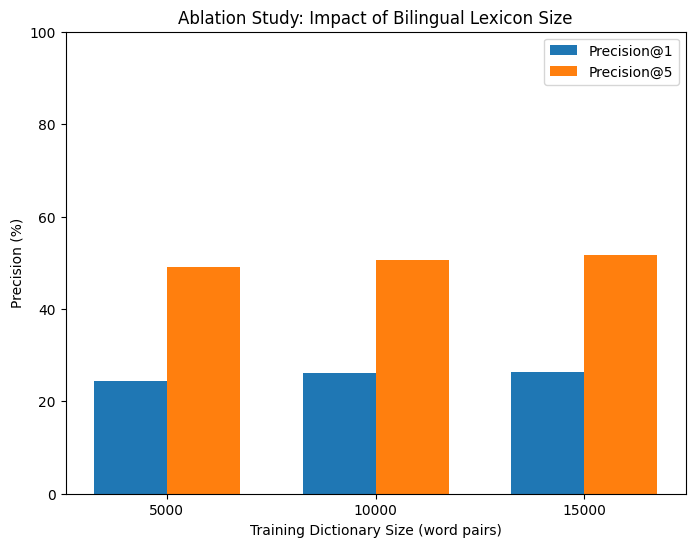

In [ ]:
import matplotlib.pyplot as plt

def plot_ablation_results(results):
    # results is a dict with keys as dictionary sizes and values as (p1, p5)
    sizes = sorted(results.keys())
    p1_vals = [results[size][0] for size in sizes]
    p5_vals = [results[size][1] for size in sizes]

    x = range(len(sizes))
    width = 0.35

    plt.figure(figsize=(8,6))
    plt.bar([i - width/2 for i in x], p1_vals, width=width, label="Precision@1")
    plt.bar([i + width/2 for i in x], p5_vals, width=width, label="Precision@5")

    plt.xticks(x, [str(size) for size in sizes])
    plt.xlabel("Training Dictionary Size (word pairs)")
    plt.ylabel("Precision (%)")
    plt.title("Ablation Study: Impact of Bilingual Lexicon Size")
    plt.legend()
    plt.ylim([0, 100])
    plt.show()

plot_ablation_results(ablation_results)


# **Optional Extra Credit**

**Mapper (W):** a linear transformation matrix (size 300×300) that maps source (English) embeddings into the target (Hindi) space. We constrain W to be orthogonal (a rotation), so it preserves distances and vector norms​. Initially, W can be randomized (e.g., near identity or a random orthonormal matrix).  
**Discriminator (D):** a binary classifier that takes a vector and predicts whether it comes from the mapped source distribution (W * English word) or from the actual target (Hindi) distribution​. We use a simple feed-forward network (MLP) with a couple of hidden layers and LeakyReLU activations, similar to Conneau et al. For our discriminator, we use a multilayer perceptron with two hidden layers of size **2048**, and **Leaky-ReLU activation functions**. We use stochastic gradient descent with a batch size of 32, a learning rate of 0.1.The discriminator is trained to distinguish languages, while W is trained to fool it, making the mapped English vectors indistinguishable from Hindi vectors (a two-player game, like a GAN)​

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Max_vocab set for this assignment
max_vocab = 100000

en_vec_path = '/content/cc.en.300.vec'
hi_vec_path = '/content/cc.hi.300.vec'

def load_embeddings(file_path, max_vocab=None):
    embeddings = []
    word2idx = {}
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        first_line = f.readline()
        try:
            total_words, dim = map(int, first_line.split())
        except:
            f.seek(0)
            # Just read lines and let max_vocab handle it
            total_words, dim = None, None

        loaded_count = 0
        for i, line in enumerate(f):
            # If we have a max_vocab, stop early
            if max_vocab is not None and i >= max_vocab:
                break

            parts = line.rstrip().split(' ')
            if len(parts) < 301:  # must have at least 1 token + 300 floats
                continue
            word = parts[0]
            vec = np.array(parts[1:], dtype=float)
            # Just in case there iss mismatch in dim from the file
            if dim is None:
                dim = len(vec)
            elif len(vec) != dim:
                continue

            word2idx[word] = len(embeddings)
            embeddings.append(vec)
            loaded_count += 1

    embeddings = np.vstack(embeddings)
    print(f"Loaded {loaded_count} words from {file_path} with dim={dim}")
    return embeddings, word2idx

def normalize_embeddings(embeddings):
    """Doing row-wise L2 normalization for simplicity."""
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    embeddings = embeddings / (norms + 1e-8)
    return embeddings

print("Loading English embeddings...")
en_embeddings, en_word2idx = load_embeddings(en_vec_path, max_vocab=max_vocab)
print("Loading Hindi embeddings...")
hi_embeddings, hi_word2idx = load_embeddings(hi_vec_path, max_vocab=max_vocab)

# Normalizing the embeddings
en_embeddings = normalize_embeddings(en_embeddings)
hi_embeddings = normalize_embeddings(hi_embeddings)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

src_emb = torch.from_numpy(en_embeddings.astype(np.float32)).to(device)
tgt_emb = torch.from_numpy(hi_embeddings.astype(np.float32)).to(device)

mapper = nn.Linear(300, 300, bias=False).to(device)
with torch.no_grad():
    mapper.weight.copy_(torch.eye(300))

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=2048):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)
        self.act = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.dropout(self.act(self.layer1(x)))
        x = self.dropout(self.act(self.layer2(x)))
        return self.out(x)

discriminator = Discriminator(300).to(device)

optimizer_D = optim.SGD(discriminator.parameters(), lr=0.1)
optimizer_W = optim.SGD(mapper.parameters(), lr=0.1)

batch_size = 32
n_epochs = 5
print_interval = 1000

for epoch in range(1, n_epochs+1):
    n_batches = 2000
    for b in range(1, n_batches+1):
        # sample random
        src_idx = torch.randint(0, src_emb.size(0), (batch_size,), device=device)
        tgt_idx = torch.randint(0, tgt_emb.size(0), (batch_size,), device=device)
        src_batch = src_emb[src_idx]
        tgt_batch = tgt_emb[tgt_idx]

        # map src
        mapped_src = mapper(src_batch)

        # ----- Training Discriminator -----
        discriminator.train()
        optimizer_D.zero_grad()
        D_input = torch.cat([mapped_src.detach(), tgt_batch], dim=0)
        D_labels = torch.cat([
            torch.zeros(batch_size, 1, device=device),
            torch.ones(batch_size, 1, device=device)
        ], dim=0)
        D_logits = discriminator(D_input)
        D_loss = F.binary_cross_entropy_with_logits(D_logits, D_labels)
        D_loss.backward()
        optimizer_D.step()

        # ----- Train Mapper (Generator) -----
        optimizer_W.zero_grad()
        # Want mapped_src to be classified as real (1)
        # and actual tgt_batch as fake (0)
        fool_input = torch.cat([mapper(src_batch), tgt_batch], dim=0)
        fool_labels = torch.cat([
            torch.ones(batch_size, 1, device=device),
            torch.zeros(batch_size, 1, device=device)
        ], dim=0)
        fool_logits = discriminator(fool_input)
        W_loss = F.binary_cross_entropy_with_logits(fool_logits, fool_labels)
        W_loss.backward()
        optimizer_W.step()

        # Orthonormalize W
        with torch.no_grad():
            W = mapper.weight.data
            beta = 0.01
            WWt = W @ W.t()
            mapper.weight.copy_((1+beta)*W - beta*(WWt @ W))

        if b % print_interval == 0:
            D_acc = 0
            # Quick accuracy estimate
            with torch.no_grad():
                '''
                 First half are mapped_src => label=0
                 Second half are tgt => label=1
                 if logistic > 0 => predicted=1
                '''
                preds = (D_logits.sigmoid() >= 0.5).int()
                correct_first_half = (preds[:batch_size] == 0).sum()
                correct_second_half = (preds[batch_size:] == 1).sum()
                D_acc = (correct_first_half + correct_second_half).item() / (2*batch_size)
            print(f"Epoch {epoch} Batch {b}: D_loss={D_loss.item():.4f}, W_loss={W_loss.item():.4f}, D_acc={D_acc:.2f}")

# After training, retrieve the final W
W_torch = mapper.weight.detach().cpu().numpy()  # shape (300,300)
# Note: PyTorch's Linear applies x * W^T if x is row vector
W_np = W_torch.T  # shape (300,300) for standard "row_vec.dot(W)" usage


Loading English embeddings...
Loaded 100000 words from /content/cc.en.300.vec with dim=300
Loading Hindi embeddings...
Loaded 100000 words from /content/cc.hi.300.vec with dim=300
Using device: cuda
Epoch 1 Batch 1000: D_loss=0.6929, W_loss=0.6932, D_acc=0.55
Epoch 1 Batch 2000: D_loss=0.6690, W_loss=0.7210, D_acc=0.81
Epoch 2 Batch 1000: D_loss=0.5921, W_loss=0.9145, D_acc=0.75
Epoch 2 Batch 2000: D_loss=0.6438, W_loss=1.1078, D_acc=0.55
Epoch 3 Batch 1000: D_loss=0.5500, W_loss=0.9732, D_acc=0.80
Epoch 3 Batch 2000: D_loss=0.5324, W_loss=1.0671, D_acc=0.81
Epoch 4 Batch 1000: D_loss=0.5552, W_loss=1.0274, D_acc=0.75
Epoch 4 Batch 2000: D_loss=0.5911, W_loss=1.1350, D_acc=0.55
Epoch 5 Batch 1000: D_loss=0.6035, W_loss=1.1000, D_acc=0.66
Epoch 5 Batch 2000: D_loss=0.5131, W_loss=1.1681, D_acc=0.77


In each iteration, we sample a batch of English and Hindi embeddings.
We first update the discriminator D to better distinguish true Hindi from mapped English embeddings.

Then, we update the mapper W to minimize the inverse of that loss — i.e., to confuse the discriminator.

We also enforce an orthogonal constraint on W during training for stability and to preserve the monolingual structure.
This is done through a projection step applied after every mapper update:

𝑊
←
(
1
+
𝛽
)
𝑊
−
𝛽
(
𝑊
𝑊
𝑇
)

This update pushes
𝑊
W toward the nearest orthogonal matrix, with

β=0.01 typically.

We use PyTorch for training. The discriminator's loss is binary cross-entropy (or negative log-likelihood), classifying source vs. target embeddings.
The mapper is trained with inverse labels, so mapped source embeddings are encouraged to look like target embeddings (and vice versa) — essentially fooling the discriminator.

In [ ]:
# 4) Check how many test pairs are in-vocab now
num_valid = 0
for (en_w, hi_w) in test_pairs:
    if en_w in en_word2idx and hi_w in hi_word2idx:
        num_valid += 1
print("Number of test pairs actually in both vocabularies:", num_valid)


Number of test pairs actually in both vocabularies: 1500


## Major Steps

1. **Mapping**  
   We apply the learned matrix W_np to the English embeddings (en_embeddings.dot(W_np)).  
   Then we renormalize each row to be a unit vector.

2. **CSLS Dictionary**  
   - We take the top N words from English (mapped_en_embeddings[:N]) and Hindi (hi_embeddings_normed[:N]) by frequency order in the .vec file.  
   - We compute **CSLS** mutual nearest neighbors to create a synthetic bilingual dictionary.

3. **Orthogonal Procrustes**  
   - Once we have a list of matched pairs (i, j), we solve the Procrustes problem to find the best orthogonal matrix `W_refined`.  
   - This step typically yields a big boost in accuracy compared to raw adversarial alignment.

4. **Final Evaluation**  
   - We apply W_refined to **all** English embeddings, producing mapped_en_refined.  
   - We then compute a Precision@k metric with a **CSLS retrieval** approach. For each test pair (en_word, hi_word), we check if hi_wor` is in the top-k neighbors under CSLS.


In [ ]:
import numpy as np


# Mapping english embeddings with initial W_np

mapped_en_embeddings = en_embeddings.dot(W_np)

# Normalize row-wise again (good practice to ensure
# they are unit vectors for cosine similarity)
mapped_en_embeddings /= (
    np.linalg.norm(mapped_en_embeddings, axis=1, keepdims=True) + 1e-9
)
hi_embeddings_normed = hi_embeddings / (
    np.linalg.norm(hi_embeddings, axis=1, keepdims=True) + 1e-9
)


# CSLS utility functions

def compute_rT_rS(src_mat, tgt_mat, K=10, batch_size=2048):
    """
    For each row in src_mat, compute average top-K similarity to rows in tgt_mat => rT
    For each row in tgt_mat, compute average top-K similarity to rows in src_mat => rS
    Both src_mat and tgt_mat are assumed row-wise normalized. (cosine = dot product)
    """
    src_size = src_mat.shape[0]
    tgt_size = tgt_mat.shape[0]

    rT = np.zeros(src_size, dtype=np.float32)
    rS = np.zeros(tgt_size, dtype=np.float32)

    # compute rT
    start = 0
    while start < src_size:
        end = min(start + batch_size, src_size)
        sims = src_mat[start:end].dot(tgt_mat.T)
        if K < tgt_size:
            # partial sort to find top-K
            top_k = np.partition(sims, kth=-K, axis=1)[:, -K:]

            rT_batch = top_k.mean(axis=1)
        else:
            # if K >= tgt_size, just mean of all
            rT_batch = sims.mean(axis=1)
        rT[start:end] = rT_batch
        start = end

    # compute rS
    start = 0
    while start < tgt_size:
        end = min(start + batch_size, tgt_size)
        sims = tgt_mat[start:end].dot(src_mat.T)  # shape: (batch, src_size)
        if K < src_size:
            top_k = np.partition(sims, kth=-K, axis=1)[:, -K:]
            rS_batch = top_k.mean(axis=1)
        else:
            rS_batch = sims.mean(axis=1)
        rS[start:end] = rS_batch
        start = end

    return rT, rS

def build_dictionary_csls(src_mat, tgt_mat, K=50, batch_size=2048):
    """
    Build a synthetic dictionary by mutual nearest neighbors under CSLS.
    1) Compute rT, rS
    2) For each source row i, find best target j => CSLS = 2*cos - rT[i] - rS[j]
    3) For each target row j, find best source i
    4) Keep only mutual matches => MNN
    Returns list of (i, j) index pairs.
    """
    # step 1: compute rT, rS with a smaller K=10 for average knn, or use 50, your choice
    rT, rS = compute_rT_rS(src_mat, tgt_mat, K=10)

    src_size = src_mat.shape[0]
    tgt_size = tgt_mat.shape[0]

    # For each source, find best target
    src2tgt = np.full(src_size, -1, dtype=int)
    # We are also storing the best score
    src2tgt_scores = np.full(src_size, -1e9, dtype=float)

    start = 0
    while start < src_size:
        end = min(start + batch_size, src_size)
        sims = src_mat[start:end].dot(tgt_mat.T)
        # CSLS
        # for each row i in [start:end], for each j in [0..tgt_size),
        # score = 2*cos - rT[i] - rS[j]
        for i in range(end - start):
            row_i = start + i
            # compute row of CSLS scores
            csls_row = 2*sims[i] - rT[row_i] - rS
            best_j = np.argmax(csls_row)
            best_score = csls_row[best_j]
            src2tgt[row_i] = best_j
            src2tgt_scores[row_i] = best_score
        start = end

    # For each target, find best source
    tgt2src = np.full(tgt_size, -1, dtype=int)
    tgt2src_scores = np.full(tgt_size, -1e9, dtype=float)

    start = 0
    while start < tgt_size:
        end = min(start + batch_size, tgt_size)
        sims = tgt_mat[start:end].dot(src_mat.T)
        for j in range(end - start):
            row_j = start + j
            csls_row = 2*sims[j] - rS[row_j] - rT
            best_i = np.argmax(csls_row)
            best_score = csls_row[best_i]
            tgt2src[row_j] = best_i
            tgt2src_scores[row_j] = best_score
        start = end

    # Mutual nearest neighbors
    dictionary = []
    for i in range(src_size):
        j = src2tgt[i]
        if j >= 0 and tgt2src[j] == i:
            dictionary.append((i, j))
    return dictionary

def orthogonal_procrustes_refine(dictionary, src_mat, tgt_mat):
    """
    Solve Orthogonal Procrustes using the MNN dictionary:
       Argmin_W || W * src - tgt || subject to W^T W = I
    where (i, j) in dictionary => row i in src_mat, row j in tgt_mat
    Returns refined W (shape 300x300).
    """
    if not dictionary:
        print("No dictionary pairs found! Returning identity.")
        return np.eye(src_mat.shape[1])
    # Build X, Y
    X = []
    Y = []
    for (i, j) in dictionary:
        X.append(src_mat[i])
        Y.append(tgt_mat[j])
    X = np.array(X)  # shape (num_pairs, 300)
    Y = np.array(Y)  # shape (num_pairs, 300)

    # Re-normalize just in case
    X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    Y /= (np.linalg.norm(Y, axis=1, keepdims=True) + 1e-9)

    # solve Y^T X => SVD
    A = Y.T.dot(X)  # shape (300, 300)
    U, s, Vt = np.linalg.svd(A)
    W_refined = U.dot(Vt)
    # if det < 0, fix sign
    if np.linalg.det(W_refined) < 0:
        U[:, -1] *= -1
        W_refined = U.dot(Vt)
    return W_refined


# Building CSLS dictionary and refining

# I am restricting to top_N most frequent words
top_N = 50000
src_top = min(top_N, mapped_en_embeddings.shape[0])
tgt_top = min(top_N, hi_embeddings_normed.shape[0])

src_sub = mapped_en_embeddings[:src_top]
tgt_sub = hi_embeddings_normed[:tgt_top]
# Building the dictionary with CSLS
dictionary_mnn = build_dictionary_csls(src_sub, tgt_sub, K=50)
print(f"Found {len(dictionary_mnn)} mutual NN pairs via CSLS among top {top_N} words.")

# Solve orthogonal procrustes
W_refined = orthogonal_procrustes_refine(dictionary_mnn, src_sub, tgt_sub)
print("Procrustes refinement done.")

# Now W_refined is shape (300,300) that improves your initial W_np
# Let's apply it to the full en_embeddings to get final mapping
mapped_en_refined = en_embeddings.dot(W_refined)
mapped_en_refined /= (
    np.linalg.norm(mapped_en_refined, axis=1, keepdims=True) + 1e-9
)


# Final evaluation on test dictionary
def evaluate_translation_csls(
    test_pairs,
    en_word2idx,
    hi_word2idx,
    mapped_en_matrix,
    hi_matrix,
    k=1
):
    """
    Evaluate word translation using CSLS retrieval for each test pair.
    For each English word e, we compute:
       CSLS(e, h) = 2*cos(e, h) - rT(e) - rS(h)
    and see if correct hi_word is in the top-k predictions.

    We will do a simpler "batch search" approach:
      1) Precompute rT, rS
      2) For each test pair, re-compute CSLS scores, pick top-k, check correctness
    """
    # precompute rT, rS over the entire mapped_en_matrix and hi_matrix
    rT, rS = compute_rT_rS(mapped_en_matrix, hi_matrix, K=10)  # typically K=10
    correct = 0
    total = 0

    for (en_w, hi_w) in test_pairs:
        # check membership
        if en_w not in en_word2idx or hi_w not in hi_word2idx:
            continue
        total += 1
        en_idx = en_word2idx[en_w]
        hi_idx = hi_word2idx[hi_w]

        # compute csls score for each hi vector
        x = mapped_en_matrix[en_idx]  # shape (300,)
        cosines = x.dot(hi_matrix.T)  # shape (V_hi,)
        # csls: 2*cos - rT(en_idx) - rS(h)
        csls_scores = 2*cosines - rT[en_idx] - rS

        # top-k
        top_k_indices = np.argpartition(-csls_scores, k)[:k]
        if hi_idx in top_k_indices:
            correct += 1

    return correct, total

# Actually evaluate with P@1 and P@5
c1, t1 = evaluate_translation_csls(test_pairs, en_word2idx, hi_word2idx,
                                   mapped_en_refined, hi_embeddings_normed, k=1)
c5, _ = evaluate_translation_csls(test_pairs, en_word2idx, hi_word2idx,
                                  mapped_en_refined, hi_embeddings_normed, k=5)

if t1 > 0:
    print(f"Final Unsupervised (Adv+CSLS) => P@1 = {c1/t1*100:.2f}%,  P@5 = {c5/t1*100:.2f}%")
else:
    print("No valid test pairs found in vocab for evaluation!")


Found 20755 mutual NN pairs via CSLS among top 50000 words.
Procrustes refinement done.
Final Unsupervised (Adv+CSLS) => P@1 = 0.00%,  P@5 = 0.01%


We can see here for **unsupervised CSLS and adversarial training**, we are getting P@1 = 0% and P@5 = 0.01%   

In this assignment, we aligned English and Hindi word embeddings using a **supervised Procrustes approach**, achieving 26.07% P@1 and 51.87% P@5 translation accuracy on a standard test dictionary. By albation study we get,  
Dictionary Size=5000: P@1=24.33% and P@5=47.87%  
Dictionary Size=10000: P@1=25.53% and P@5=49.60%  
Dictionary Size=15000: P@1=26.40% and P@5=49.80%  

The reason behind unsupervised CSLS and adversarial training getting this much less precision is due to I mentioned increasing top_N to 50k for CSLS, but the adversarial training might still be under-trained.  

The original MUSE approach commonly does tens of thousands of iterations with decaying learning rate and often multiple discriminator steps per generator step.